In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix
import seaborn as sns
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import defaultdict
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from sklearn.metrics import classification_report
from collections import defaultdict

BATCH_SIZE = 32
EPOCHS = 25
LR = 0.001
IMAGE_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models

class MobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetV2, self).__init__()

        # Loading pretrained MobileNetV2
        mobilenet = models.mobilenet_v2(pretrained=True)

        # Feature extractor 
        self.features = mobilenet.features
        for param in self.features.parameters():
            param.requires_grad = True
        for layer in list(self.features.children())[-2:]:
            for param in layer.parameters():
               param.requires_grad = True

        # Classifier 
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(mobilenet.last_channel, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.mean([2, 3])  # global average pooling
        x = self.classifier(x)
        return x
smodel =MobileNetV2(num_classes=7).to(DEVICE)


scriterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 111MB/s] 


In [ ]:
"""class RelationNetwork(nn.Module):
    def __init__(self, emb_size=512, dropout_rate=0.2):
        super().__init__()
        # Feature Embedder
        self.encoder = nn.Sequential(
            *list(resnet18(pretrained=True).children())[:-1],
            nn.Flatten(),
            nn.Dropout(0.2)
        )
        # Relation Module with Dropout and BatchNorm
        self.relation = nn.Sequential(
            nn.Linear(emb_size * 2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, support, queries):
        # Encode all images
        combined = torch.cat([support, queries], dim=0)
        embeddings = self.encoder(combined)

        # Split back into support and queries
        support_emb = embeddings[:support.size(0)]
        query_emb = embeddings[support.size(0):]

        # Create class prototypes
        prototypes = support_emb.view(3, 5, -1).mean(1)

        # Create relation pairs
        relations = []
        for query in query_emb:
            for proto in prototypes:
                relations.append(torch.cat([query, proto], dim=0))
        relations = torch.stack(relations)

        # Compute relation scores
        scores = self.relation(relations).view(len(query_emb), 3)
        return scores


# Initialize model with custom dropout rate
fmodel = RelationNetwork(dropout_rate=0.0).to(DEVICE)
fmodel = RelationNetwork().to(DEVICE)
fcriterion = nn.MSELoss()"""

In [3]:
class RelationNetwork(nn.Module):
    def __init__(self, emb_size=128, dropout_rate=0.1):
        super().__init__()

        # Use MobileNetV2 as a lightweight encoder
        mobilenet = models.mobilenet_v2(pretrained=True)
        self.encoder = nn.Sequential(
            mobilenet.features,          # Output shape: [B, 1280, 7, 7]
            nn.AdaptiveAvgPool2d((1, 1)), # [B, 1280, 1, 1]
            nn.Flatten(),                # [B, 1280]
            nn.Linear(1280, emb_size),   # Reduce dimensionality
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Lighter relation module
        self.relation = nn.Sequential(
            nn.Linear(emb_size * 2, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, support, queries):
        # Encode all images
        combined = torch.cat([support, queries], dim=0)
        embeddings = self.encoder(combined)

        # Split back into support and queries
        support_emb = embeddings[:support.size(0)]
        query_emb = embeddings[support.size(0):]

        # Create class prototypes
        prototypes = support_emb.view(3, 5, -1).mean(1)

        # Create relation pairs
        relations = []
        for query in query_emb:
            for proto in prototypes:
                relations.append(torch.cat([query, proto], dim=0))
        relations = torch.stack(relations)

        # Compute relation scores
        scores = self.relation(relations).view(len(query_emb), 3)
        return scores



In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import os

# ======== CONFIG ========= #
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved supervised model
supervised_model = MobileNetV2(num_classes=7)
supervised_model.load_state_dict(torch.load("/kaggle/input/hybrid/pytorch/default/1/best_model_final_supervised_rare_aug.pth", map_location=DEVICE))
supervised_model.to(DEVICE)
supervised_model.eval()

# Load the saved few-shot model
fewshot_model = RelationNetwork()
fewshot_model.load_state_dict(torch.load("/kaggle/input/relation_net_best_loss/pytorch/default/1/best_relation_mobile_net_loss0.0775.pth", map_location=DEVICE))
fewshot_model.to(DEVICE)
fewshot_model.eval()

# Supervised test dataset to get class mapping
test_dataset = ImageFolder('/kaggle/input/final-supervised-rare-aug/Final_Supervised - Rare/Val')
supervised_idx_to_class = test_dataset.classes
RARE_CLASS_IDX = supervised_idx_to_class.index("Rare")  

# Few-shot class labels
fewshot_idx_to_class = ['Edema', 'Fibrosis', 'Hernia']

# Shared image transform
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# ======== SUPPORT SET LOADER ========= #
def load_support_set():
    
    root = "/kaggle/input/100rare-split/100Rare_split/train"  
    class_dirs = ['Edema', 'Fibrosis', 'Hernia']

    support_images = []
    for label, class_name in enumerate(class_dirs):
        class_path = os.path.join(root, class_name)
        image_files = os.listdir(class_path)[:5]  # Use first 5 images
        for img_name in image_files:
            img_path = os.path.join(class_path, img_name)
            image = Image.open(img_path).convert("RGB")
            img_tensor = test_transforms(image)
            support_images.append(img_tensor)
    
    support_tensor = torch.stack(support_images)  # Shape: [15, 3, 224, 224]
    return support_tensor.to(DEVICE)



In [18]:
results = []
counter=0
for root, _, files in os.walk(test_images_dir):
    for file in files:
        if file.endswith((".jpg", ".png")):
            img_path = os.path.join(root, file)

            # Step 1: Predict using supervised model
            image = Image.open(img_path).convert("RGB")
            image_tensor = test_transforms(image).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                logits = supervised_model(image_tensor)
                probs = F.softmax(logits, dim=1)
                pred_idx = torch.argmax(probs, dim=1).item()

            supervised_class = supervised_idx_to_class[pred_idx]

            # Step 2: Route to few-shot if Rare
            if pred_idx == RARE_CLASS_IDX:
                with torch.no_grad():
                    counter+=1
                    print(str(counter)+":"+f"Image → Supervised: Rare → Routing to Few-Shot")
                    fewshot_scores = fewshot_model(support_tensor, image_tensor)
                    fewshot_pred_idx = torch.argmax(fewshot_scores, dim=1).item()
                    final_class = fewshot_idx_to_class[fewshot_pred_idx]
                was_routed = True
            else:
                final_class = supervised_class
                was_routed = False

            results.append((file, final_class, was_routed))


1:Image → Supervised: Rare → Routing to Few-Shot
2:Image → Supervised: Rare → Routing to Few-Shot
3:Image → Supervised: Rare → Routing to Few-Shot
4:Image → Supervised: Rare → Routing to Few-Shot
5:Image → Supervised: Rare → Routing to Few-Shot
6:Image → Supervised: Rare → Routing to Few-Shot
7:Image → Supervised: Rare → Routing to Few-Shot
8:Image → Supervised: Rare → Routing to Few-Shot
9:Image → Supervised: Rare → Routing to Few-Shot
10:Image → Supervised: Rare → Routing to Few-Shot
11:Image → Supervised: Rare → Routing to Few-Shot
12:Image → Supervised: Rare → Routing to Few-Shot
13:Image → Supervised: Rare → Routing to Few-Shot
14:Image → Supervised: Rare → Routing to Few-Shot
15:Image → Supervised: Rare → Routing to Few-Shot
16:Image → Supervised: Rare → Routing to Few-Shot
17:Image → Supervised: Rare → Routing to Few-Shot
18:Image → Supervised: Rare → Routing to Few-Shot
19:Image → Supervised: Rare → Routing to Few-Shot
20:Image → Supervised: Rare → Routing to Few-Shot
21:Image 


========== 🔀 Hybrid Model Evaluation ==========

Samples evaluated: 1721
              precision    recall  f1-score   support

        COPD      1.000     1.000     1.000       351
    Covid-19      0.960     0.870     0.913       300
   Emphysema      0.880     0.968     0.922       250
      Normal      0.980     0.990     0.985       300
   Pneumonia      1.000     0.988     0.994       428
Tuberculosis      0.942     1.000     0.970        65
       Edema      0.900     1.000     0.947         9
    Fibrosis      0.889     0.889     0.889         9
      Hernia      0.889     0.889     0.889         9

    accuracy                          0.967      1721
   macro avg      0.938     0.955     0.945      1721
weighted avg      0.968     0.967     0.967      1721



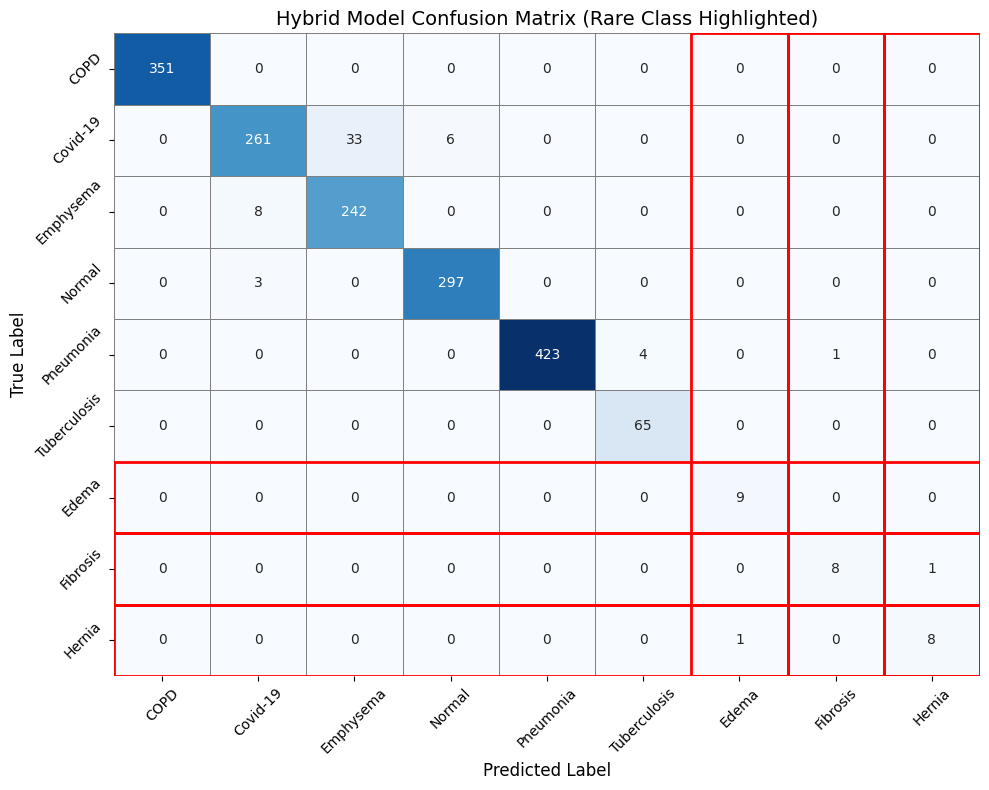


========== Per-Class Accuracy ==========
COPD           : 1.000
Covid-19       : 0.870
Emphysema      : 0.968
Normal         : 0.990
Pneumonia      : 0.988
Tuberculosis   : 1.000
Edema          : 1.000
Fibrosis       : 0.889
Hernia         : 0.889


In [19]:
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# === Class definitions ===
fewshot_classes = ['Edema', 'Fibrosis', 'Hernia']
supervised_classes = ['COPD', 'Covid-19', 'Emphysema', 'Normal', 'Pneumonia', 'Rare', 'Tuberculosis']
hybrid_classes = ['COPD', 'Covid-19', 'Emphysema', 'Normal', 'Pneumonia', 'Tuberculosis', 'Edema', 'Fibrosis', 'Hernia']

# === Paths ===
test_images_dir = "/kaggle/input/final-supervised-rare-aug/Final_Supervised - Rare/Val"
fewshot_test_root = "/kaggle/input/100rare-split/100Rare_split/test"

# === Routed filenames ===
routed_rare_filenames = [fname for fname, _, routed in results if routed]

# === True label maps ===
true_label_map = {}
for class_name in supervised_classes:
    class_dir = os.path.join(test_images_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    for fname in os.listdir(class_dir):
        
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            true_label_map[fname] = class_name

true_subclass_map = {}
for subclass in fewshot_classes:
    subclass_dir = os.path.join(fewshot_test_root, subclass)
    for fname in os.listdir(subclass_dir):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            true_subclass_map[fname] = subclass

# === Evaluation build ===
hybrid_y_true, hybrid_y_pred = [], []

for fname_full, pred, was_routed in results:
    fname = os.path.basename(fname_full)
    
    if fname not in true_label_map: 
        continue
    gt = true_label_map[fname]
    if gt == "Rare":
        if not was_routed:
            continue
        gt = true_subclass_map.get(fname)
        if gt is None:
            continue

    hybrid_y_true.append(gt)
    hybrid_y_pred.append(pred)

# === Classification Report ===
print("\n========== Hybrid Model Evaluation ==========\n")
print(f"Samples evaluated: {len(hybrid_y_true)}")
print(classification_report(
    hybrid_y_true,
    hybrid_y_pred,
    labels=hybrid_classes,
    digits=3,
    zero_division=0
))

# === Confusion Matrix ===
cm = confusion_matrix(hybrid_y_true, hybrid_y_pred, labels=hybrid_classes)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=hybrid_classes,
                 yticklabels=hybrid_classes,
                 linewidths=0.5, linecolor='gray',
                 cbar=False)

fewshot_idxs = [hybrid_classes.index(c) for c in fewshot_classes]
for idx in fewshot_idxs:
    ax.add_patch(plt.Rectangle((0, idx), len(hybrid_classes), 1,
                               fill=False, edgecolor='red', lw=2))
    ax.add_patch(plt.Rectangle((idx, 0), 1, len(hybrid_classes),
                               fill=False, edgecolor='red', lw=2))

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Hybrid Model Confusion Matrix (Rare Class Highlighted)", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# === Step 7: Per-Class Accuracy ===
print("\n========== Per-Class Accuracy ==========")
per_class_accuracy = {}
for idx, class_name in enumerate(hybrid_classes):
    true_positives = cm[idx, idx]
    total_actual = cm[idx].sum()
    accuracy = true_positives / total_actual if total_actual > 0 else 0.0
    per_class_accuracy[class_name] = accuracy
    print(f"{class_name:15}: {accuracy:.3f}")

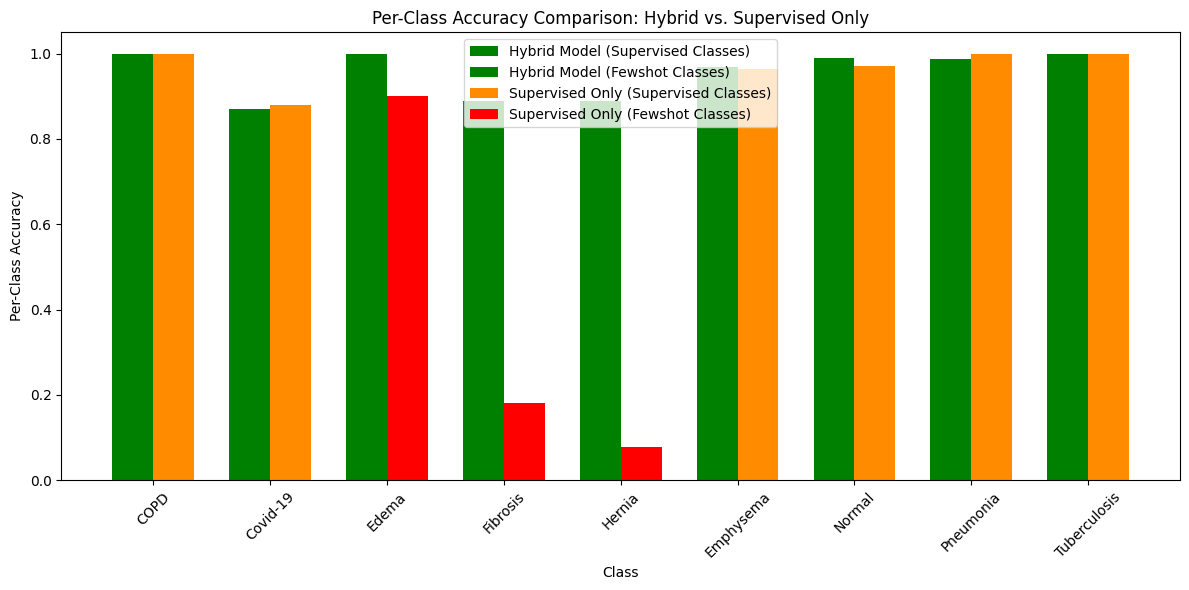

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Classes (order aligned with your data)
classes = ['COPD', 'Covid-19', 'Edema', 'Fibrosis', 'Hernia', 'Emphysema', 'Normal', 'Pneumonia', 'Tuberculosis']

# Hybrid per-class accuracy values
hybrid_acc = [1.000, 0.870, 1.000, 0.889, 0.889, 0.968, 0.990, 0.988, 1.000]

# Supervised-only per-class accuracy values
supervised_acc = [1.0000, 0.8800, 0.9000, 0.1818, 0.0769, 0.9640, 0.9700, 1.0000, 1.0000]

# Identify fewshot class indices
fewshot_classes = ['Edema', 'Fibrosis', 'Hernia']
fewshot_indices = [classes.index(cls) for cls in fewshot_classes]

x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(12, 6))

# Plot bars with different colors for fewshot classes
for i in range(len(classes)):
    color_hybrid = 'green' if i in fewshot_indices else 'green'
    color_supervised = 'red' if i in fewshot_indices else 'darkorange'
    
    plt.bar(x[i] - width/2, hybrid_acc[i], width, color=color_hybrid)
    plt.bar(x[i] + width/2, supervised_acc[i], width, color=color_supervised)

plt.ylabel('Per-Class Accuracy')
plt.xlabel('Class')
plt.title('Per-Class Accuracy Comparison: Hybrid vs. Supervised Only')
plt.xticks(x, classes, rotation=45)
plt.ylim(0, 1.05)

# Legend handles for colors
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', label='Hybrid Model (Supervised Classes)'),
    Patch(facecolor='green', label='Hybrid Model (Fewshot Classes)'),
    Patch(facecolor='darkorange', label='Supervised Only (Supervised Classes)'),
    Patch(facecolor='red', label='Supervised Only (Fewshot Classes)'),
]

plt.legend(handles=legend_elements)
plt.tight_layout()
plt.show()


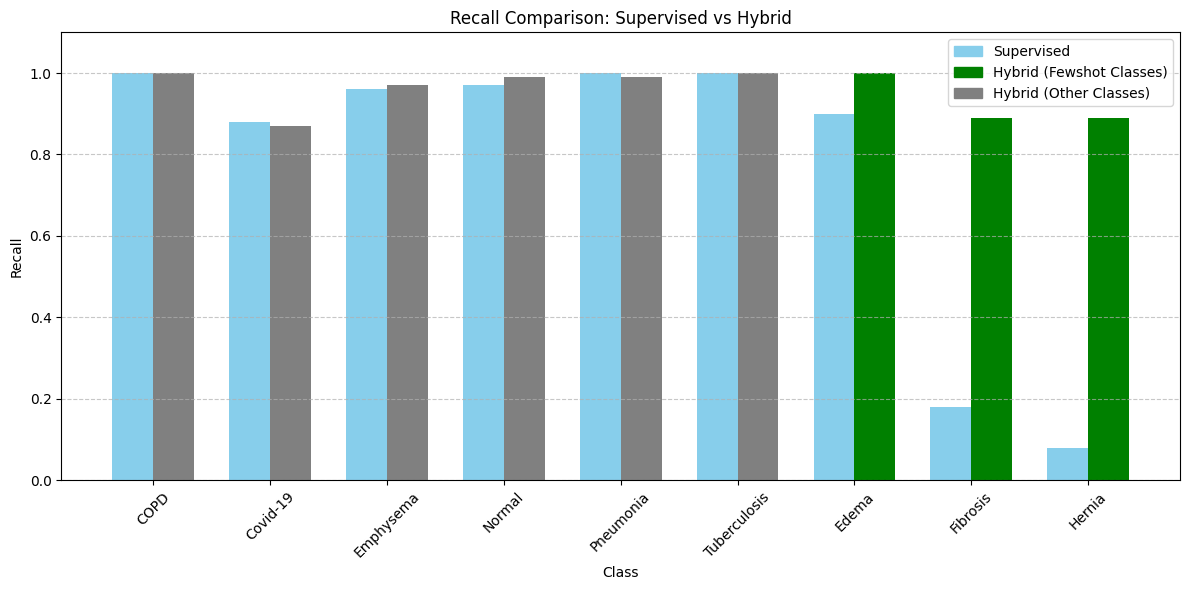

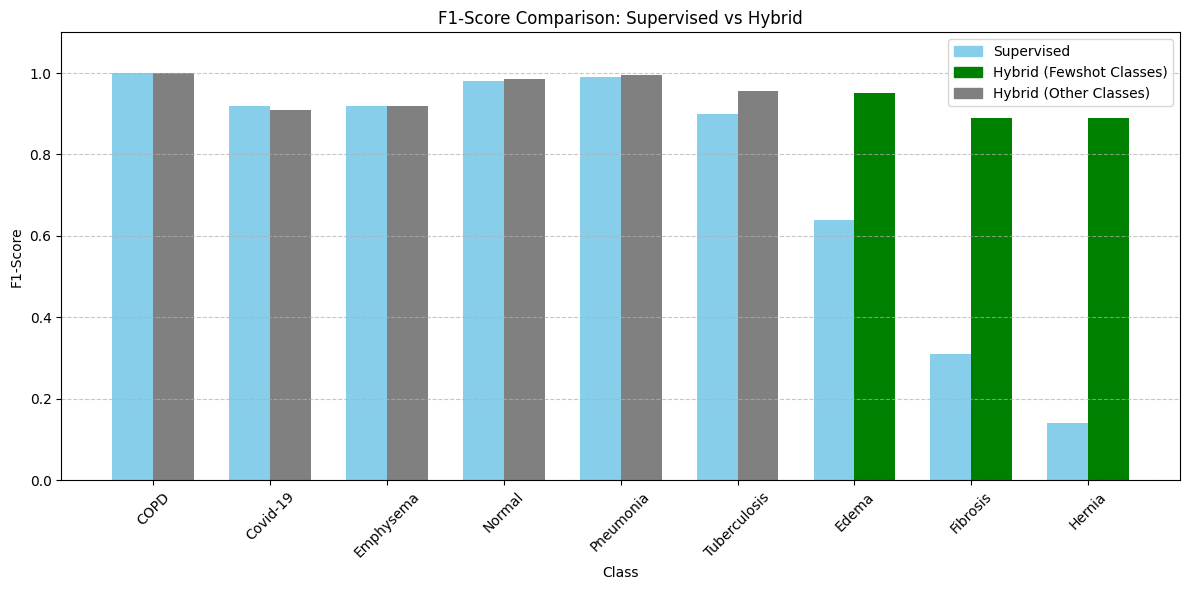

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Classes
classes = ['COPD', 'Covid-19', 'Emphysema', 'Normal', 'Pneumonia', 'Tuberculosis',
           'Edema', 'Fibrosis', 'Hernia']

fewshot_classes = ['Edema', 'Fibrosis', 'Hernia']
fewshot_indices = [classes.index(c) for c in fewshot_classes]

def plot_metric_comparison(hybrid_vals, normal_vals, metric_name):
    x = np.arange(len(classes))
    width = 0.35

    plt.figure(figsize=(12, 6))

    # Plot Supervised bars (all same color)
    plt.bar(x - width/2, normal_vals, width, label='Supervised', color='skyblue')

    # Plot Hybrid bars with conditional coloring
    for i in range(len(classes)):
        color = 'green' if i in fewshot_indices else 'gray'
        plt.bar(x[i] + width/2, hybrid_vals[i], width, color=color)

    plt.ylabel(metric_name)
    plt.xlabel("Class")
    plt.title(f"{metric_name} Comparison: Supervised vs Hybrid")
    plt.xticks(x, classes, rotation=45)
    plt.ylim(0, 1.1)
    
    # Create custom legend for hybrid bars with two colors
    import matplotlib.patches as mpatches
    legend_elements = [
        mpatches.Patch(color='skyblue', label='Supervised'),
        mpatches.Patch(color='green', label='Hybrid (Fewshot Classes)'),
        mpatches.Patch(color='gray', label='Hybrid (Other Classes)'),
    ]
    plt.legend(handles=legend_elements)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Your data here (unchanged)
hybrid_precision = [1.00, 0.96, 0.88, 0.98, 1.00, 0.915, 0.90, 0.889, 0.889]
normal_precision = [1.00, 0.96, 0.89, 0.99, 0.98, 0.82, 0.50, 1.00, 1.00]

hybrid_recall    = [1.00, 0.87, 0.97, 0.99, 0.99, 1.00, 1.00, 0.889, 0.889]
normal_recall    = [1.00, 0.88, 0.96, 0.97, 1.00, 1.00, 0.90, 0.18, 0.08]

hybrid_f1        = [1.00, 0.91, 0.92, 0.985, 0.994, 0.956, 0.95, 0.889, 0.889]
normal_f1        = [1.00, 0.92, 0.92, 0.98, 0.99, 0.90, 0.64, 0.31, 0.14]

# Generate plots
#plot_metric_comparison(hybrid_precision, normal_precision, "Precision")
plot_metric_comparison(hybrid_recall, normal_recall, "Recall")
plot_metric_comparison(hybrid_f1, normal_f1, "F1-Score")
plot_metric_comparison(hybrid_precision, normal_precision, "Precision")

In [ ]:
from sklearn.metrics import classification_report
import os

fewshot_test_root = "/kaggle/input/100rare-split/100Rare_split/test"
fewshot_classes = ['Edema', 'Fibrosis', 'Hernia']
supervised_classes = [cls for cls in supervised_idx_to_class if cls != "Rare"] 


true_label_map = {}

# From supervised test dataset (non-Rare)
for class_name in supervised_classes:
    class_dir = os.path.join(test_images_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            true_label_map[fname] = class_name


true_subclass_map = {}
for subclass in fewshot_classes:
    subclass_dir = os.path.join(fewshot_test_root, subclass)
    for fname in os.listdir(subclass_dir):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            true_subclass_map[fname] = subclass


fewshot_y_true, fewshot_y_pred = [], []
supervised_y_true, supervised_y_pred = [], []


for fname_full, pred, _ in results:
    fname = os.path.basename(fname_full)

    if fname in true_subclass_map:
        # Only include if this sample was routed to few-shot
        if pred in fewshot_classes:  #Predicted by few-shot model
            fewshot_y_true.append(true_subclass_map[fname])
            fewshot_y_pred.append(pred)
    elif fname in true_label_map:
        true_class = true_label_map[fname]
        supervised_y_true.append(true_class)
        supervised_y_pred.append(pred)
# === Step 4: Print classification reports ===
print("\n==========Few-Shot Model Evaluation (Only Routed Images) ==========\n")
print(f"Samples evaluated: {len(fewshot_y_true)}")
print(classification_report(
    fewshot_y_true,
    fewshot_y_pred,
    labels=fewshot_classes,
    digits=3
))

print("\n==========Supervised Model Evaluation (Non-Rare Only)==========\n")
print(f"Samples evaluated: {len(supervised_y_true)}")
print(classification_report(
    supervised_y_true,
    supervised_y_pred,
    labels=supervised_classes,
    digits=3
))

In [9]:
"""from sklearn.metrics import classification_report
import os

fewshot_test_root = "/kaggle/input/100rare-split/100Rare_split/test"
fewshot_classes = ['Edema', 'Fibrosis', 'Hernia']
supervised_classes = [cls for cls in supervised_idx_to_class if cls != "Rare"] 

# === Step 1: Build true label map ===
true_label_map = {}

# From supervised test dataset (non-Rare)
for class_name in supervised_classes:
    class_dir = os.path.join(test_images_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            true_label_map[fname] = class_name

# === Step 1: Build true subclass label map ===
true_subclass_map = {}
for subclass in fewshot_classes:
    subclass_dir = os.path.join(fewshot_test_root, subclass)
    for fname in os.listdir(subclass_dir):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            true_subclass_map[fname] = subclass

# === Step 2: Initialize report lists ===
fewshot_y_true, fewshot_y_pred = [], []
supervised_y_true, supervised_y_pred = [], []

# === Step 3: Evaluate each result ===
for fname_full, pred in results:
    fname = os.path.basename(fname_full)

    if fname in true_subclass_map:
        # Only include if this sample was routed to few-shot
        if pred in fewshot_classes:  #Predicted by few-shot model
            fewshot_y_true.append(true_subclass_map[fname])
            fewshot_y_pred.append(pred)
    elif fname in true_label_map:
        true_class = true_label_map[fname]
        supervised_y_true.append(true_class)
        supervised_y_pred.append(pred)

# === Step 4: Print classification reports ===
print("\n==========Few-Shot Model Evaluation (Only Routed Images) ==========\n")
print(f"Samples evaluated: {len(fewshot_y_true)}")
print(classification_report(
    fewshot_y_true,
    fewshot_y_pred,
    labels=fewshot_classes,
    digits=3
))

print("\n==========Supervised Model Evaluation (Non-Rare Only)==========\n")
print(f"Samples evaluated: {len(supervised_y_true)}")
print(classification_report(
    supervised_y_true,
    supervised_y_pred,
    labels=supervised_classes,
    digits=3
))
"""

'from sklearn.metrics import classification_report\nimport os\n\nfewshot_test_root = "/kaggle/input/100rare-split/100Rare_split/test"\nfewshot_classes = [\'Edema\', \'Fibrosis\', \'Hernia\']\nsupervised_classes = [cls for cls in supervised_idx_to_class if cls != "Rare"] \n\n# === Step 1: Build true label map ===\ntrue_label_map = {}\n\n# From supervised test dataset (non-Rare)\nfor class_name in supervised_classes:\n    class_dir = os.path.join(test_images_dir, class_name)\n    if not os.path.isdir(class_dir):\n        continue\n    for fname in os.listdir(class_dir):\n        if fname.endswith((".png", ".jpg", ".jpeg")):\n            true_label_map[fname] = class_name\n\n# === Step 1: Build true subclass label map ===\ntrue_subclass_map = {}\nfor subclass in fewshot_classes:\n    subclass_dir = os.path.join(fewshot_test_root, subclass)\n    for fname in os.listdir(subclass_dir):\n        if fname.endswith((".png", ".jpg", ".jpeg")):\n            true_subclass_map[fname] = subclass\n\n

In [10]:
"""import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# === Class definitions ===
fewshot_classes = ['Edema', 'Fibrosis', 'Hernia']
supervised_classes = ['COPD', 'Covid-19', 'Emphysema', 'Normal', 'Pneumonia', 'Rare', 'Tuberculosis']
hybrid_classes = ['COPD', 'Covid-19', 'Emphysema', 'Normal', 'Pneumonia', 'Tuberculosis', 'Edema', 'Fibrosis', 'Hernia']

# === Paths ===
test_images_dir = "/kaggle/input/final-supervised-rare-aug/Final_Supervised - Rare/Test"
fewshot_test_root = "/kaggle/input/100rare-split/100Rare_split/test"

# === Load routed rare image filenames (you must build this list during inference) ===
# Assume you saved the routed fewshot image filenames during inference
# Example:
# routed_rare_filenames = ['0001.png', '0002.png', ..., '0030.png']
# You must define this from your inference step

# Dummy placeholder (replace with your actual routed list)
routed_rare_filenames = [os.path.basename(p[0]) for p in results if p[1] in fewshot_classes]

# === Step 1: Build true_label_map (from supervised test set including Rare) ===
true_label_map = {}
for class_name in supervised_classes:
    class_dir = os.path.join(test_images_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            true_label_map[fname] = class_name

# === Step 2: Build true_subclass_map from few-shot test set ===
true_subclass_map = {}
for subclass in fewshot_classes:
    subclass_dir = os.path.join(fewshot_test_root, subclass)
    for fname in os.listdir(subclass_dir):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            true_subclass_map[fname] = subclass

# === Step 3: Build hybrid prediction and true labels ===
hybrid_y_true, hybrid_y_pred = [] , []

for fname_full, pred in results:
    fname = os.path.basename(fname_full)

    if fname in true_label_map:
        gt = true_label_map[fname]

        if gt == "Rare":
            if fname not in routed_rare_filenames:
                continue  # Skip un-routed Rare image
            if fname in true_subclass_map:
                gt = true_subclass_map[fname]
            else:
                #print(f"⚠️ Warning: Routed Rare image not found in few-shot ground truth: {fname}")
                continue

        hybrid_y_true.append(gt)
        hybrid_y_pred.append(pred)
    else:
        continue
        #print(f"⚠️ Skipping unknown image: {fname}")

# === Step 4: Classification Report ===
print("\n========== 🔀 Hybrid Model Evaluation ==========\n")
print(f"Samples evaluated: {len(hybrid_y_true)}")
print(classification_report(
    hybrid_y_true,
    hybrid_y_pred,
    labels=hybrid_classes,
    digits=3
))

# === Step 5: Confusion Matrix ===
cm = confusion_matrix(hybrid_y_true, hybrid_y_pred, labels=hybrid_classes)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=hybrid_classes,
                 yticklabels=hybrid_classes,
                 linewidths=0.5, linecolor='gray',
                 cbar=False)

# === Step 6: Highlight few-shot rows/cols ===
fewshot_idxs = [hybrid_classes.index(c) for c in fewshot_classes]

for idx in fewshot_idxs:
    # Highlight row
    ax.add_patch(plt.Rectangle((0, idx), len(hybrid_classes), 1,
                               fill=False, edgecolor='red', lw=2, linestyle='-'))
    # Highlight column
    ax.add_patch(plt.Rectangle((idx, 0), 1, len(hybrid_classes),
                               fill=False, edgecolor='red', lw=2, linestyle='-'))

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Hybrid Model Confusion Matrix (🔶 Few-shot Highlighted)", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# === Step 7: Per-Class Accuracy ===
print("\n========== Per-Class Accuracy ==========")
per_class_accuracy = {}
for idx, class_name in enumerate(hybrid_classes):
    true_positives = cm[idx, idx]
    total_actual = cm[idx].sum()
    accuracy = true_positives / total_actual if total_actual > 0 else 0.0
    per_class_accuracy[class_name] = accuracy
    print(f"{class_name:15}: {accuracy:.3f}")
"""

'import os\nfrom collections import Counter\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.metrics import classification_report, confusion_matrix\n\n# === Class definitions ===\nfewshot_classes = [\'Edema\', \'Fibrosis\', \'Hernia\']\nsupervised_classes = [\'COPD\', \'Covid-19\', \'Emphysema\', \'Normal\', \'Pneumonia\', \'Rare\', \'Tuberculosis\']\nhybrid_classes = [\'COPD\', \'Covid-19\', \'Emphysema\', \'Normal\', \'Pneumonia\', \'Tuberculosis\', \'Edema\', \'Fibrosis\', \'Hernia\']\n\n# === Paths ===\ntest_images_dir = "/kaggle/input/final-supervised-rare-aug/Final_Supervised - Rare/Test"\nfewshot_test_root = "/kaggle/input/100rare-split/100Rare_split/test"\n\n# === Load routed rare image filenames (you must build this list during inference) ===\n# Assume you saved the routed fewshot image filenames during inference\n# Example:\n# routed_rare_filenames = [\'0001.png\', \'0002.png\', ..., \'0030.png\']\n# You must define this from your infe

In [11]:
"""import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ===Few-Shot Confusion Matrix ===
if fewshot_y_true:
    cm_fewshot = confusion_matrix(fewshot_y_true, fewshot_y_pred, labels=fewshot_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_fewshot, annot=True, fmt="d", cmap="Blues",
                xticklabels=fewshot_classes, yticklabels=fewshot_classes)
    plt.title("Few-Shot Model Confusion Matrix (Routed 'Rare' Samples)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
else:
    print("No few-shot predictions to show confusion matrix.")

# ===Supervised Confusion Matrix ===
if supervised_y_true:
    cm_supervised = confusion_matrix(supervised_y_true, supervised_y_pred, labels=supervised_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_supervised, annot=True, fmt="d", cmap="Greens",
                xticklabels=supervised_classes, yticklabels=supervised_classes)
    plt.title("Supervised Model Confusion Matrix (Non-Rare Samples)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
else:
    print("No supervised predictions to show confusion matrix.")
"""

'import matplotlib.pyplot as plt\nimport seaborn as sns\nfrom sklearn.metrics import confusion_matrix\n\n# ===Few-Shot Confusion Matrix ===\nif fewshot_y_true:\n    cm_fewshot = confusion_matrix(fewshot_y_true, fewshot_y_pred, labels=fewshot_classes)\n    plt.figure(figsize=(6, 5))\n    sns.heatmap(cm_fewshot, annot=True, fmt="d", cmap="Blues",\n                xticklabels=fewshot_classes, yticklabels=fewshot_classes)\n    plt.title("Few-Shot Model Confusion Matrix (Routed \'Rare\' Samples)")\n    plt.xlabel("Predicted")\n    plt.ylabel("True")\n    plt.tight_layout()\n    plt.show()\nelse:\n    print("No few-shot predictions to show confusion matrix.")\n\n# ===Supervised Confusion Matrix ===\nif supervised_y_true:\n    cm_supervised = confusion_matrix(supervised_y_true, supervised_y_pred, labels=supervised_classes)\n    plt.figure(figsize=(8, 6))\n    sns.heatmap(cm_supervised, annot=True, fmt="d", cmap="Greens",\n                xticklabels=supervised_classes, yticklabels=supervised_

In [12]:
"""from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Define classes
hybrid_classes = ['COPD', 'Covid-19', 'Emphysema', 'Normal', 'Pneumonia', 'Tuberculosis', 'Edema', 'Fibrosis', 'Hernia']
fewshot_classes = ['Edema', 'Fibrosis', 'Hernia']

# === Hybrid Evaluation ===
print("\n========== 🌐 Hybrid Model Evaluation ==========\n")
print(f"Samples evaluated: {len(hybrid_y_true)}")
print(classification_report(
    hybrid_y_true,
    hybrid_y_pred,
    labels=hybrid_classes,
    digits=3
))

# === Confusion Matrix (Highlight Few-Shot) ===
cm = confusion_matrix(hybrid_y_true, hybrid_y_pred, labels=hybrid_classes)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                 xticklabels=hybrid_classes, yticklabels=hybrid_classes)

# Highlight few-shot class cells (red box)
fewshot_idx = [hybrid_classes.index(cls) for cls in fewshot_classes]
for i in fewshot_idx:
    for j in range(len(hybrid_classes)):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=1.5))
        ax.add_patch(plt.Rectangle((i, j), 1, 1, fill=False, edgecolor='red', lw=1.5))

plt.title("Hybrid Model Confusion Matrix (🔴 Few-shot Highlighted)", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# === Per-Class Accuracy ===
print("\n========== 📊 Per-Class Accuracy ==========")
for idx, class_name in enumerate(hybrid_classes):
    tp = cm[idx, idx]
    total = cm[idx].sum()
    acc = tp / total if total > 0 else 0.0
    print(f"{class_name:15}: {acc:.3f}")

# === Few-Shot Only Evaluation (among 3 Rare Classes only) ===
fewshot_y_true_filtered = []
fewshot_y_pred_filtered = []

for yt, yp in zip(hybrid_y_true, hybrid_y_pred):
    if yt in fewshot_classes:
        if yp in fewshot_classes:
            # Correctly routed and predicted among few-shot classes
            fewshot_y_true_filtered.append(yt)
            fewshot_y_pred_filtered.append(yp)
        else:
            # Was supposed to be rare, but misclassified as supervised class → skip
            continue

print("\n========== 🔍 Few-Shot Class Evaluation (Only Routed & Classified among 3 Rare Classes) ==========")
print(f"Samples evaluated: {len(fewshot_y_true_filtered)}")
print(classification_report(
    fewshot_y_true_filtered,
    fewshot_y_pred_filtered,
    labels=fewshot_classes,
    digits=3
))

# Optional: Few-shot confusion matrix only
cm_fewshot = confusion_matrix(fewshot_y_true_filtered, fewshot_y_pred_filtered, labels=fewshot_classes)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_fewshot, annot=True, fmt="d", cmap="Greens",
            xticklabels=fewshot_classes, yticklabels=fewshot_classes)
plt.title("Few-Shot Submatrix (Rare Class Confusion Only)", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()"""

'from sklearn.metrics import classification_report, confusion_matrix\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport numpy as np\nfrom collections import Counter\n\n# Define classes\nhybrid_classes = [\'COPD\', \'Covid-19\', \'Emphysema\', \'Normal\', \'Pneumonia\', \'Tuberculosis\', \'Edema\', \'Fibrosis\', \'Hernia\']\nfewshot_classes = [\'Edema\', \'Fibrosis\', \'Hernia\']\n\n# === Hybrid Evaluation ===\nprint("\n========== 🌐 Hybrid Model Evaluation ==========\n")\nprint(f"Samples evaluated: {len(hybrid_y_true)}")\nprint(classification_report(\n    hybrid_y_true,\n    hybrid_y_pred,\n    labels=hybrid_classes,\n    digits=3\n))\n\n# === Confusion Matrix (Highlight Few-Shot) ===\ncm = confusion_matrix(hybrid_y_true, hybrid_y_pred, labels=hybrid_classes)\n\nplt.figure(figsize=(10, 8))\nax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",\n                 xticklabels=hybrid_classes, yticklabels=hybrid_classes)\n\n# Highlight few-shot class cells (red box)\nfewshot_i

'import matplotlib.pyplot as plt\nimport numpy as np\nimport pandas as pd\n\n# === Manually enter the classification results ===\n\nclasses = [\'COPD\', \'Covid-19\', \'Emphysema\', \'Normal\', \'Pneumonia\', \'Tuberculosis\',\n           \'Edema\', \'Fibrosis\', \'Hernia\']\n\n# Scores for each class (in same order as above)\n\n# From Hybrid Model\nhybrid_precision = [1.00, 0.96, 0.88, 0.98, 1.00, 0.915, 0.90, 0.889, 0.889]\nhybrid_recall    = [1.00, 0.87, 0.97, 0.99, 0.99, 1.00, 0.90, 0.80, 0.889]\nhybrid_f1        = [1.00, 0.91, 0.92, 0.985, 0.994, 0.956, 0.90, 0.842, 0.889]\n\n# From Normal Supervised Model\nnormal_precision = [1.00, 0.96, 0.89, 0.99, 0.98, 0.82, 0.50, 1.00, 1.00]\nnormal_recall    = [1.00, 0.88, 0.96, 0.97, 1.00, 1.00, 0.90, 0.18, 0.08]\nnormal_f1        = [1.00, 0.92, 0.92, 0.98, 0.99, 0.90, 0.64, 0.31, 0.14]\n\n# === Plotting function ===\ndef plot_metric_comparison(hybrid_vals, normal_vals, metric_name):\n    x = np.arange(len(classes))\n    width = 0.35\n\n   

In [14]:
"""from sklearn.metrics import classification_report
import os

fewshot_test_root = "/kaggle/input/100rare-split/100Rare_split/test"
fewshot_classes = ['Edema', 'Fibrosis', 'Hernia']
supervised_classes = [cls for cls in supervised_idx_to_class] #if cls != "Rare"

# === Step 1: Build true label map ===
true_label_map = {}

# From supervised test dataset (non-Rare)
for class_name in supervised_classes:
    class_dir = os.path.join(test_images_dir, class_name)
    if not os.path.isdir(class_dir):
        continue
    for fname in os.listdir(class_dir):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            true_label_map[fname] = class_name

# === Step 1: Build true subclass label map ===
true_subclass_map = {}
for subclass in fewshot_classes:
    subclass_dir = os.path.join(fewshot_test_root, subclass)
    for fname in os.listdir(subclass_dir):
        if fname.endswith((".png", ".jpg", ".jpeg")):
            true_subclass_map[fname] = subclass

# === Step 2: Initialize report lists ===
fewshot_y_true, fewshot_y_pred = [], []
supervised_y_true, supervised_y_pred = [], []

# === Step 3: Evaluate each result ===
for fname_full, pred in results:
    fname = os.path.basename(fname_full)

    if fname in true_subclass_map:
        # Only include if this sample was routed to few-shot
        if pred in fewshot_classes:  #Predicted by few-shot model
            fewshot_y_true.append(true_subclass_map[fname])
            fewshot_y_pred.append(pred)
    elif fname in true_label_map:
        true_class = true_label_map[fname]
        supervised_y_true.append(true_class)
        supervised_y_pred.append(pred)

# === Step 4: Print classification reports ===
print("\n==========Few-Shot Model Evaluation (Only Routed Images) ==========\n")
print(f"Samples evaluated: {len(fewshot_y_true)}")
print(classification_report(
    fewshot_y_true,
    fewshot_y_pred,
    labels=fewshot_classes,
    digits=3
))

print("\n==========Supervised Model Evaluation (Non-Rare Only)==========\n")
print(f"Samples evaluated: {len(supervised_y_true)}")
print(classification_report(
    supervised_y_true,
    supervised_y_pred,
    labels=supervised_classes,
    digits=3
))
"""

'from sklearn.metrics import classification_report\nimport os\n\nfewshot_test_root = "/kaggle/input/100rare-split/100Rare_split/test"\nfewshot_classes = [\'Edema\', \'Fibrosis\', \'Hernia\']\nsupervised_classes = [cls for cls in supervised_idx_to_class] #if cls != "Rare"\n\n# === Step 1: Build true label map ===\ntrue_label_map = {}\n\n# From supervised test dataset (non-Rare)\nfor class_name in supervised_classes:\n    class_dir = os.path.join(test_images_dir, class_name)\n    if not os.path.isdir(class_dir):\n        continue\n    for fname in os.listdir(class_dir):\n        if fname.endswith((".png", ".jpg", ".jpeg")):\n            true_label_map[fname] = class_name\n\n# === Step 1: Build true subclass label map ===\ntrue_subclass_map = {}\nfor subclass in fewshot_classes:\n    subclass_dir = os.path.join(fewshot_test_root, subclass)\n    for fname in os.listdir(subclass_dir):\n        if fname.endswith((".png", ".jpg", ".jpeg")):\n            true_subclass_map[fname] = subclass\n\n